## This notebook is a demo for

1. Testing the convergence between the grf-approximated covariance matrix to the ground truth diffusion kernel.

In [31]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import math

In [32]:
import sys
import os
project_root = os.path.abspath("..")
sys.path.append(project_root)

In [33]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, feature_matrix_kernel, generate_noisy_samples, grf_kernel
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [34]:
# Parameters
num_nodes = 10
graph_type = 'line' # 'line', 'random'
np.random.seed(0)
BETA = 2

In [35]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix

In [36]:
ground_truth = diffusion_kernel(adj_matrix=adjacency_matrix, beta=0.1)

In [37]:
def diffusion_modulation_function(length):
    beta = BETA
    numerator = (-beta)**length
    denominator = 2**length * math.factorial(length)
    return numerator / denominator

In [38]:
grf_matrix = grf_kernel(adj_matrix=adjacency_matrix,
                        walks_per_node=20,
                        p_halt=0.1,
                        modulation_function=diffusion_modulation_function)

In [39]:
# Plotting function
def plot_heatmaps(walks_per_node_sample, p_halt_sample):
    beta= BETA  # Fixed beta value
    # Compute Ground Truth and GRF Matrix
    ground_truth = diffusion_kernel(adjacency_matrix, beta)
    grf_matrix = grf_kernel(adjacency_matrix, walks_per_node_sample, p_halt=p_halt_sample, modulation_function=diffusion_modulation_function)
    
    # Create the plots
    plt.figure(figsize=(12, 6))
    
    # Heatmap for Ground Truth
    plt.subplot(1, 2, 1)
    sns.heatmap(ground_truth, annot=True, cmap='viridis', cbar=True)
    plt.title(f"Ground Truth (Beta={beta})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    # Heatmap for GRF Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(grf_matrix, annot=True, cmap='viridis', cbar=True)
    plt.title(f"GRF Matrix (Walks Per Node={walks_per_node_sample}, p_halt={p_halt_sample:.2f})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    plt.tight_layout()
    plt.show()

# Interactive widgets
walks_per_node_slider = widgets.IntSlider(value=20, min=10, max=1000, step=10, description='Walks Per Node:')
p_halt_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='p_halt:')

# Interactive output
ui = widgets.VBox([walks_per_node_slider, p_halt_slider])
out = widgets.interactive_output(plot_heatmaps, {
    'walks_per_node_sample': walks_per_node_slider,
    'p_halt_sample': p_halt_slider
})

# Display widgets and plots
display(ui, out)


Output()

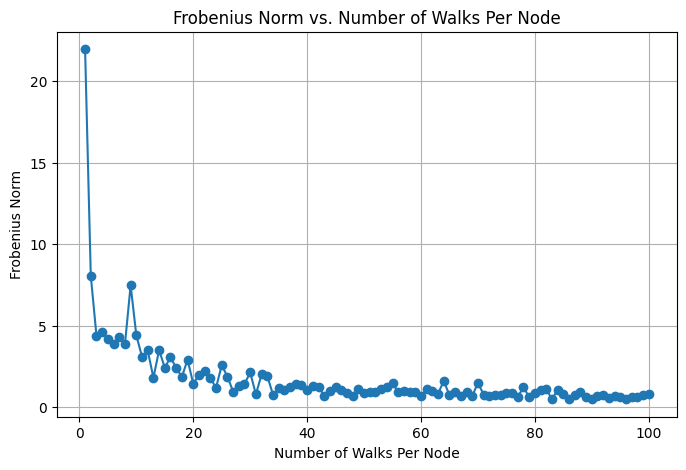

In [40]:
# Plot Frobenius norm vs. number of walks per node
def plot_frobenius_norm(adjacency_matrix, p_halt, max_walks_per_node=100):
    beta_sample = BETA  # Fixed beta value
    ground_truth = diffusion_kernel(adjacency_matrix, beta_sample)
    
    norms = []
    walks_range = range(1, max_walks_per_node + 1)
    
    for walks_per_node in walks_range:
        grf_matrix = grf_kernel(adjacency_matrix, walks_per_node, p_halt, modulation_function=diffusion_modulation_function)
        norm = compute_fro(ground_truth, grf_matrix)
        norms.append(norm)
    
    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(walks_range, norms, marker='o')
    plt.title("Frobenius Norm vs. Number of Walks Per Node")
    plt.xlabel("Number of Walks Per Node")
    plt.ylabel("Frobenius Norm")
    plt.grid(True)
    plt.show()

# Example usage
plot_frobenius_norm(adjacency_matrix, p_halt=0.1)